# Post Transforms with spleen segmentation task

MONAI provides post-processing transforms for handling the model outputs. Currently, the transforms include:
* `Activations`: Adding activation layer (Sigmoid, Softmax, etc.).
* `AsDiscrete`: Converting to discrete values (Argmax, One-Hot, Threshold value, etc).
* `SplitChannel`: Splitting multi-channel data into multiple single channels.
* `KeepLargestConnectedComponent`: Extracting contour of segmentation result, which can be used to map to original image and evaluate the model.
* `LabelToContour`: Removing segmentation noise based on Connected Component Analysis.

MONAI supports multiple transform chains to apply different pre-transforms or post-transforms on the same data and concatenate the results, it provides `CopyItems` transform to make copies of specified items in the data dictionary and `ConcatItems` transform to combine specified items on the expected dimension, and also provides `DeleteItems` transform to delete unnecessary items to save memory.

A typical usage is to scale and concatenate 3 different intensity ranges of an input image:
<p>
<img src="./images/multi_transform_chains.png" width="70%" alt='multi_transform_chains'>
</p>

This tutorial shows several of above post transforms based on the model output of spleen segmentation.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/MONAI/blob/master/examples/notebooks/post_transforms.ipynb)

## Setup environment

In [1]:
%pip install -qU "monai[gdown, nibabel, skimage]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -qU matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    Compose,
    CropForegroundd,
    KeepLargestConnectedComponent,
    LabelToContour,
    LoadNiftid,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.1.0+318.ga2cd842.dirty
Python version: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31)  [GCC 7.3.0]
Numpy version: 1.18.1
Pytorch version: 1.6.0

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.0.1
scikit-image version: 0.15.0
Pillow version: 7.0.0
Tensorboard version: 2.1.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Download dataset

Downloads and extracts the dataset.
The dataset comes from http://medicaldecathlon.com/.

In [5]:
resource = "https://drive.google.com/uc?id=1jzeNU1EKnK81PyTsrx0ujfNl-t0Jo8uE"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [6]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)

## Setup transforms for training and validation

In [8]:
train_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # randomly crop out patch samples from big image based on pos / neg ratio
        # the image centers of negative samples must be in valid image area
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

## Define CacheDataset and DataLoader for training and validation

In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

32/32 Load and cache transformed data:  [==============================]
9/9 Load and cache transformed data:  [==============================]


## Create Model, Loss, Optimizer

In [10]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

## Execute a typical PyTorch training process

In [11]:
epoch_num = 160
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    # validation progress
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                    to_onehot_y=True,
                    mutually_exclusive=True,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

----------
epoch 1/180
1/16, train_loss: 0.6793
2/16, train_loss: 0.7039
3/16, train_loss: 0.6945
4/16, train_loss: 0.6785
5/16, train_loss: 0.6725
6/16, train_loss: 0.6783
7/16, train_loss: 0.6761
8/16, train_loss: 0.6690
9/16, train_loss: 0.6688
10/16, train_loss: 0.6590
11/16, train_loss: 0.6771
12/16, train_loss: 0.6320
13/16, train_loss: 0.6597
14/16, train_loss: 0.6682
15/16, train_loss: 0.6530
16/16, train_loss: 0.6613
epoch 1 average loss: 0.6707
----------
epoch 2/180
1/16, train_loss: 0.6817
2/16, train_loss: 0.6537
3/16, train_loss: 0.6207
4/16, train_loss: 0.6519
5/16, train_loss: 0.6680
6/16, train_loss: 0.6320
7/16, train_loss: 0.6318
8/16, train_loss: 0.6772
9/16, train_loss: 0.6579
10/16, train_loss: 0.6375
11/16, train_loss: 0.6373
12/16, train_loss: 0.6395
13/16, train_loss: 0.6120
14/16, train_loss: 0.6284
15/16, train_loss: 0.6436
16/16, train_loss: 0.6384
epoch 2 average loss: 0.6445
saved new best metric model
current epoch: 2 current mean dice: 0.0319
best mean d

3/16, train_loss: 0.5664
4/16, train_loss: 0.5128
5/16, train_loss: 0.5415
6/16, train_loss: 0.5180
7/16, train_loss: 0.4948
8/16, train_loss: 0.4758
9/16, train_loss: 0.4949
10/16, train_loss: 0.4238
11/16, train_loss: 0.4943
12/16, train_loss: 0.5210
13/16, train_loss: 0.4963
14/16, train_loss: 0.5873
15/16, train_loss: 0.4999
16/16, train_loss: 0.4527
epoch 17 average loss: 0.5054
----------
epoch 18/180
1/16, train_loss: 0.4887
2/16, train_loss: 0.4723
3/16, train_loss: 0.4330
4/16, train_loss: 0.5290
5/16, train_loss: 0.4791
6/16, train_loss: 0.5421
7/16, train_loss: 0.4963
8/16, train_loss: 0.5365
9/16, train_loss: 0.5139
10/16, train_loss: 0.4852
11/16, train_loss: 0.5133
12/16, train_loss: 0.4992
13/16, train_loss: 0.4681
14/16, train_loss: 0.4534
15/16, train_loss: 0.4829
16/16, train_loss: 0.4954
epoch 18 average loss: 0.4930
current epoch: 18 current mean dice: 0.0574
best mean dice: 0.1041 at epoch: 14
----------
epoch 19/180
1/16, train_loss: 0.5470
2/16, train_loss: 0.511

11/16, train_loss: 0.3325
12/16, train_loss: 0.4246
13/16, train_loss: 0.3302
14/16, train_loss: 0.3625
15/16, train_loss: 0.5099
16/16, train_loss: 0.3592
epoch 33 average loss: 0.3964
----------
epoch 34/180
1/16, train_loss: 0.3614
2/16, train_loss: 0.4074
3/16, train_loss: 0.3376
4/16, train_loss: 0.4333
5/16, train_loss: 0.3821
6/16, train_loss: 0.3803
7/16, train_loss: 0.4023
8/16, train_loss: 0.3556
9/16, train_loss: 0.3962
10/16, train_loss: 0.4482
11/16, train_loss: 0.3722
12/16, train_loss: 0.4459
13/16, train_loss: 0.4175
14/16, train_loss: 0.3901
15/16, train_loss: 0.3498
16/16, train_loss: 0.3918
epoch 34 average loss: 0.3920
current epoch: 34 current mean dice: 0.0726
best mean dice: 0.1041 at epoch: 14
----------
epoch 35/180
1/16, train_loss: 0.4026
2/16, train_loss: 0.3390
3/16, train_loss: 0.4195
4/16, train_loss: 0.3458
5/16, train_loss: 0.3834
6/16, train_loss: 0.4418
7/16, train_loss: 0.3121
8/16, train_loss: 0.4123
9/16, train_loss: 0.4233
10/16, train_loss: 0.353

1/16, train_loss: 0.2673
2/16, train_loss: 0.3449
3/16, train_loss: 0.3418
4/16, train_loss: 0.3509
5/16, train_loss: 0.3740
6/16, train_loss: 0.3726
7/16, train_loss: 0.3691
8/16, train_loss: 0.3340
9/16, train_loss: 0.3567
10/16, train_loss: 0.2585
11/16, train_loss: 0.2291
12/16, train_loss: 0.2019
13/16, train_loss: 0.2832
14/16, train_loss: 0.3332
15/16, train_loss: 0.3612
16/16, train_loss: 0.3307
epoch 50 average loss: 0.3193
current epoch: 50 current mean dice: 0.0625
best mean dice: 0.1041 at epoch: 14
----------
epoch 51/180
1/16, train_loss: 0.4146
2/16, train_loss: 0.3692
3/16, train_loss: 0.2640
4/16, train_loss: 0.3070
5/16, train_loss: 0.3182
6/16, train_loss: 0.3829
7/16, train_loss: 0.3530
8/16, train_loss: 0.3327
9/16, train_loss: 0.3256
10/16, train_loss: 0.2986
11/16, train_loss: 0.2624
12/16, train_loss: 0.3284
13/16, train_loss: 0.3850
14/16, train_loss: 0.3068
15/16, train_loss: 0.2980
16/16, train_loss: 0.2933
epoch 51 average loss: 0.3275
----------
epoch 52/18

9/16, train_loss: 0.1974
10/16, train_loss: 0.2546
11/16, train_loss: 0.2623
12/16, train_loss: 0.3745
13/16, train_loss: 0.3105
14/16, train_loss: 0.2502
15/16, train_loss: 0.3554
16/16, train_loss: 0.3099
epoch 66 average loss: 0.2979
current epoch: 66 current mean dice: 0.0436
best mean dice: 0.1041 at epoch: 14
----------
epoch 67/180
1/16, train_loss: 0.3805
2/16, train_loss: 0.1554
3/16, train_loss: 0.3922
4/16, train_loss: 0.3280
5/16, train_loss: 0.3244
6/16, train_loss: 0.3700
7/16, train_loss: 0.2558
8/16, train_loss: 0.3144
9/16, train_loss: 0.2833
10/16, train_loss: 0.3471
11/16, train_loss: 0.2725
12/16, train_loss: 0.2363
13/16, train_loss: 0.3076
14/16, train_loss: 0.2491
15/16, train_loss: 0.2641
16/16, train_loss: 0.2537
epoch 67 average loss: 0.2959
----------
epoch 68/180
1/16, train_loss: 0.2041
2/16, train_loss: 0.1781
3/16, train_loss: 0.2559
4/16, train_loss: 0.2312
5/16, train_loss: 0.1935
6/16, train_loss: 0.3423
7/16, train_loss: 0.2067
8/16, train_loss: 0.436

16/16, train_loss: 0.1473
epoch 82 average loss: 0.2566
current epoch: 82 current mean dice: 0.0413
best mean dice: 0.1041 at epoch: 14
----------
epoch 83/180
1/16, train_loss: 0.2946
2/16, train_loss: 0.2515
3/16, train_loss: 0.3545
4/16, train_loss: 0.2452
5/16, train_loss: 0.2794
6/16, train_loss: 0.1825
7/16, train_loss: 0.2711
8/16, train_loss: 0.2604
9/16, train_loss: 0.2632
10/16, train_loss: 0.2544
11/16, train_loss: 0.1955
12/16, train_loss: 0.2070
13/16, train_loss: 0.3739
14/16, train_loss: 0.3021
15/16, train_loss: 0.2530
16/16, train_loss: 0.2576
epoch 83 average loss: 0.2654
----------
epoch 84/180
1/16, train_loss: 0.2100
2/16, train_loss: 0.3084
3/16, train_loss: 0.2564
4/16, train_loss: 0.1502
5/16, train_loss: 0.1568
6/16, train_loss: 0.2182
7/16, train_loss: 0.1806
8/16, train_loss: 0.1834
9/16, train_loss: 0.1536
10/16, train_loss: 0.4102
11/16, train_loss: 0.3411
12/16, train_loss: 0.2306
13/16, train_loss: 0.1383
14/16, train_loss: 0.2084
15/16, train_loss: 0.143

2/16, train_loss: 0.1799
3/16, train_loss: 0.1704
4/16, train_loss: 0.2356
5/16, train_loss: 0.1245
6/16, train_loss: 0.3472
7/16, train_loss: 0.1531
8/16, train_loss: 0.3267
9/16, train_loss: 0.1538
10/16, train_loss: 0.3711
11/16, train_loss: 0.1393
12/16, train_loss: 0.2416
13/16, train_loss: 0.2353
14/16, train_loss: 0.1334
15/16, train_loss: 0.1303
16/16, train_loss: 0.3325
epoch 99 average loss: 0.2173
----------
epoch 100/180
1/16, train_loss: 0.1568
2/16, train_loss: 0.1875
3/16, train_loss: 0.1945
4/16, train_loss: 0.1809
5/16, train_loss: 0.2863
6/16, train_loss: 0.2285
7/16, train_loss: 0.2332
8/16, train_loss: 0.2885
9/16, train_loss: 0.3447
10/16, train_loss: 0.2325
11/16, train_loss: 0.4235
12/16, train_loss: 0.2102
13/16, train_loss: 0.1101
14/16, train_loss: 0.2224
15/16, train_loss: 0.2859
16/16, train_loss: 0.3462
epoch 100 average loss: 0.2457
current epoch: 100 current mean dice: 0.0612
best mean dice: 0.1041 at epoch: 14
----------
epoch 101/180
1/16, train_loss: 0

6/16, train_loss: 0.2215
7/16, train_loss: 0.4250
8/16, train_loss: 0.1760
9/16, train_loss: 0.2235
10/16, train_loss: 0.1683
11/16, train_loss: 0.2700
12/16, train_loss: 0.3353
13/16, train_loss: 0.1197
14/16, train_loss: 0.2571
15/16, train_loss: 0.2121
16/16, train_loss: 0.3410
epoch 115 average loss: 0.2450
----------
epoch 116/180
1/16, train_loss: 0.1255
2/16, train_loss: 0.2845
3/16, train_loss: 0.1736
4/16, train_loss: 0.4023
10/16, train_loss: 0.1116
11/16, train_loss: 0.3213
12/16, train_loss: 0.1630
13/16, train_loss: 0.2173
14/16, train_loss: 0.1614
15/16, train_loss: 0.2518
16/16, train_loss: 0.2187
epoch 130 average loss: 0.2126
current epoch: 130 current mean dice: 0.1017
best mean dice: 0.2240 at epoch: 114
----------
epoch 131/180
1/16, train_loss: 0.2653
2/16, train_loss: 0.2767
3/16, train_loss: 0.3280
4/16, train_loss: 0.2312
5/16, train_loss: 0.2187
6/16, train_loss: 0.1660
7/16, train_loss: 0.1214
8/16, train_loss: 0.2176
9/16, train_loss: 0.1729
10/16, train_loss

14/16, train_loss: 0.1698
15/16, train_loss: 0.1462
16/16, train_loss: 0.1041
epoch 145 average loss: 0.1938
----------
epoch 146/180
1/16, train_loss: 0.2217
2/16, train_loss: 0.2173
3/16, train_loss: 0.3238
4/16, train_loss: 0.2170
5/16, train_loss: 0.3356
6/16, train_loss: 0.2176
7/16, train_loss: 0.1471
8/16, train_loss: 0.2792
9/16, train_loss: 0.2014
10/16, train_loss: 0.3345
11/16, train_loss: 0.0996
12/16, train_loss: 0.1075
13/16, train_loss: 0.0980
14/16, train_loss: 0.1626
15/16, train_loss: 0.3250
16/16, train_loss: 0.2715
epoch 146 average loss: 0.2225
saved new best metric model
current epoch: 146 current mean dice: 0.6089
best mean dice: 0.6089 at epoch: 146
----------
epoch 147/180
1/16, train_loss: 0.1809
2/16, train_loss: 0.1511
3/16, train_loss: 0.2422
4/16, train_loss: 0.1034
5/16, train_loss: 0.2808
6/16, train_loss: 0.2637
7/16, train_loss: 0.2148
8/16, train_loss: 0.2779
9/16, train_loss: 0.3668
10/16, train_loss: 0.3289
11/16, train_loss: 0.1549
12/16, train_los

1/16, train_loss: 0.3247
2/16, train_loss: 0.2751
3/16, train_loss: 0.0987
4/16, train_loss: 0.2717
5/16, train_loss: 0.2521
6/16, train_loss: 0.2221
7/16, train_loss: 0.1679
8/16, train_loss: 0.2083
9/16, train_loss: 0.1537
10/16, train_loss: 0.1448
11/16, train_loss: 0.2135
12/16, train_loss: 0.2660
13/16, train_loss: 0.2185
14/16, train_loss: 0.2751
15/16, train_loss: 0.0312
16/16, train_loss: 0.2048
epoch 162 average loss: 0.2080
current epoch: 162 current mean dice: 0.3680
best mean dice: 0.8437 at epoch: 156
----------
epoch 163/180
1/16, train_loss: 0.1603
2/16, train_loss: 0.2181
3/16, train_loss: 0.1480
4/16, train_loss: 0.2359
5/16, train_loss: 0.3383
6/16, train_loss: 0.2632
7/16, train_loss: 0.1177
8/16, train_loss: 0.2073
9/16, train_loss: 0.1609
10/16, train_loss: 0.1627
11/16, train_loss: 0.1448
12/16, train_loss: 0.0954
13/16, train_loss: 0.1013
14/16, train_loss: 0.2121
15/16, train_loss: 0.2099
16/16, train_loss: 0.0902
epoch 163 average loss: 0.1791
----------
epoch 

4/16, train_loss: 0.2665
5/16, train_loss: 0.2082
6/16, train_loss: 0.1607
7/16, train_loss: 0.1547
8/16, train_loss: 0.2712
9/16, train_loss: 0.2032
10/16, train_loss: 0.2289
11/16, train_loss: 0.2907
12/16, train_loss: 0.2051
13/16, train_loss: 0.0528
14/16, train_loss: 0.2042
15/16, train_loss: 0.0866
16/16, train_loss: 0.2173
epoch 178 average loss: 0.1983
current epoch: 178 current mean dice: 0.8788
best mean dice: 0.9283 at epoch: 174
----------
epoch 179/180
1/16, train_loss: 0.2961
2/16, train_loss: 0.2138
3/16, train_loss: 0.1507
4/16, train_loss: 0.2826
5/16, train_loss: 0.2635
6/16, train_loss: 0.0892
7/16, train_loss: 0.1652
8/16, train_loss: 0.2070
9/16, train_loss: 0.2142
10/16, train_loss: 0.1510
11/16, train_loss: 0.3124
12/16, train_loss: 0.0891
13/16, train_loss: 0.0313
14/16, train_loss: 0.2253
15/16, train_loss: 0.2037
16/16, train_loss: 0.1086
epoch 179 average loss: 0.1877
----------
epoch 180/180
1/16, train_loss: 0.2420
2/16, train_loss: 0.1162
3/16, train_loss:

## Execute post transforms on validation dataset

Here we test `AsDiscrete`, `KeepLargestConnectedComponent` and `LabelToContour`.

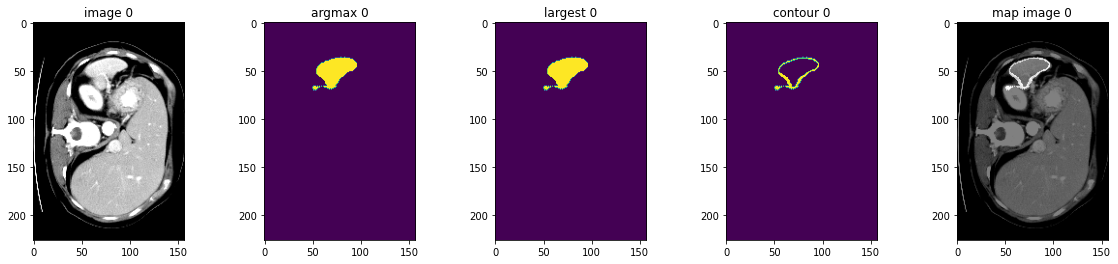

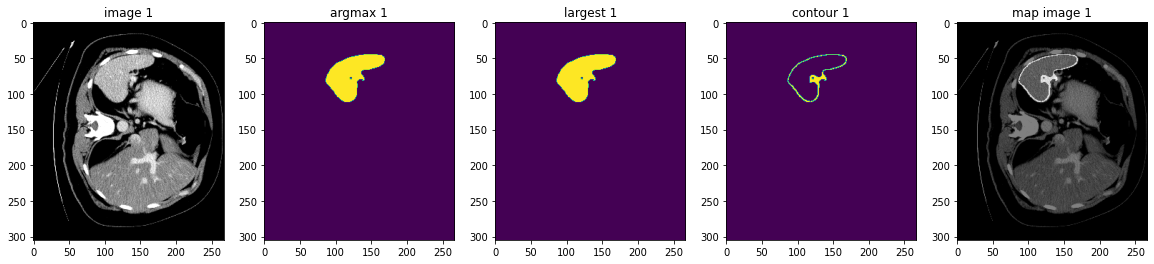

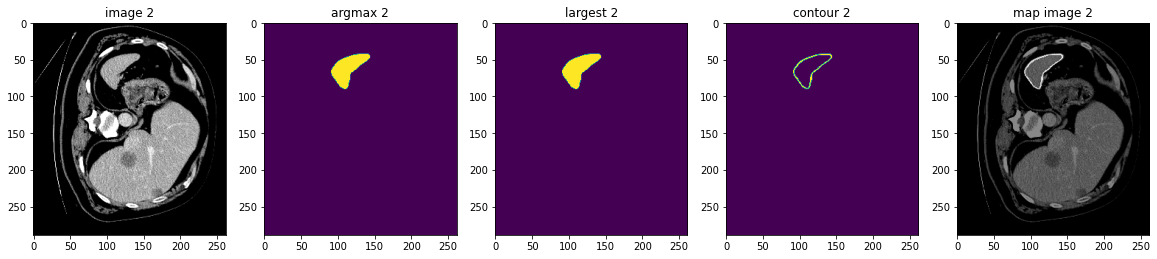

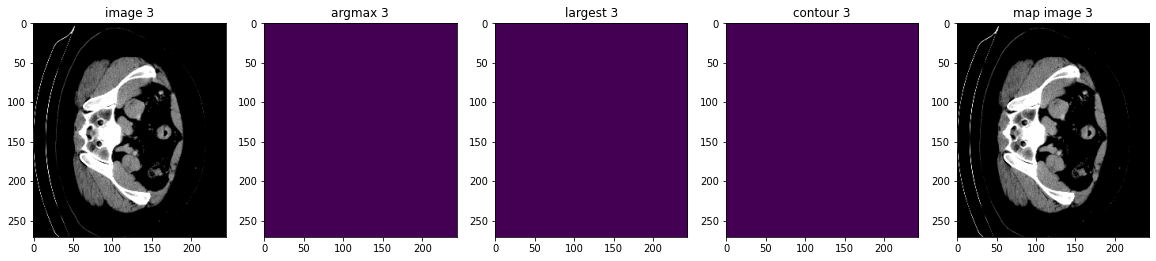

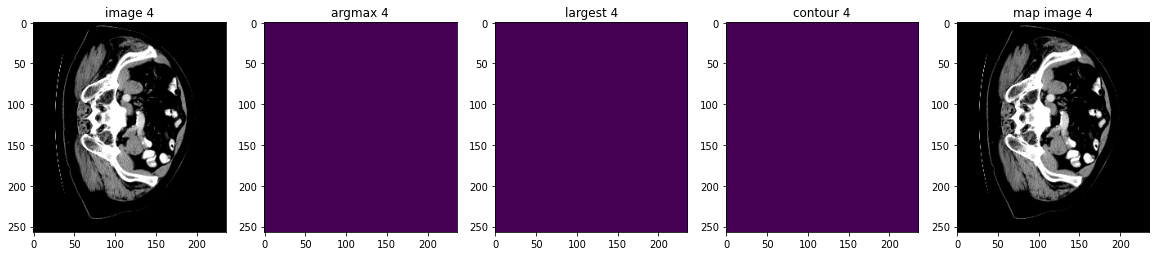

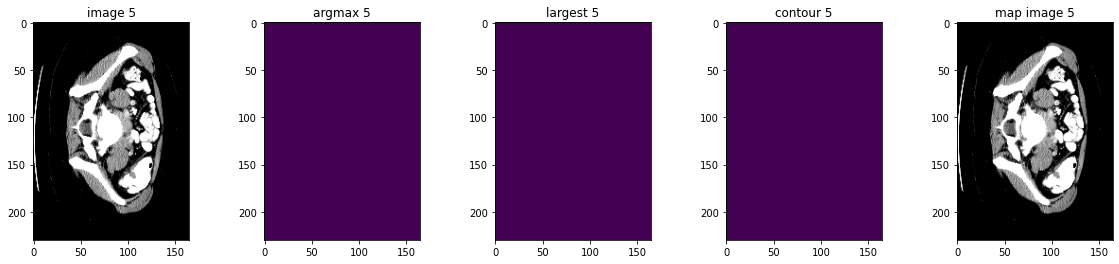

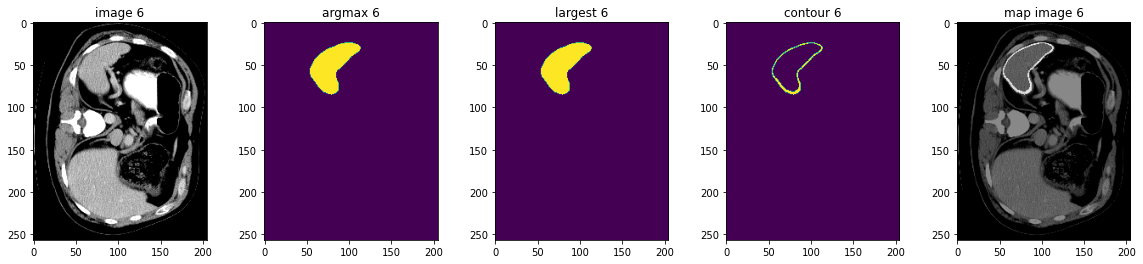

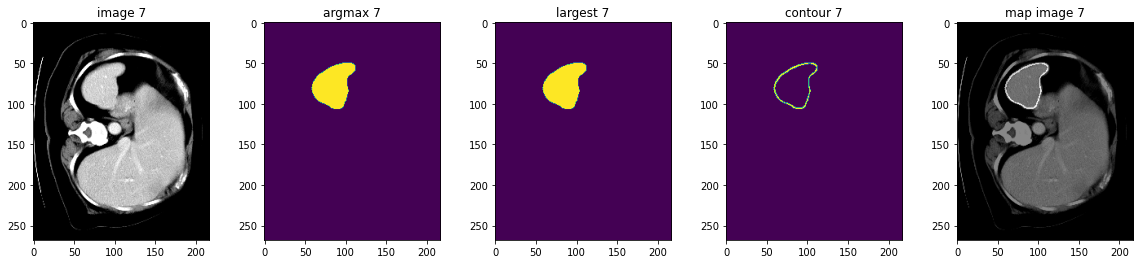

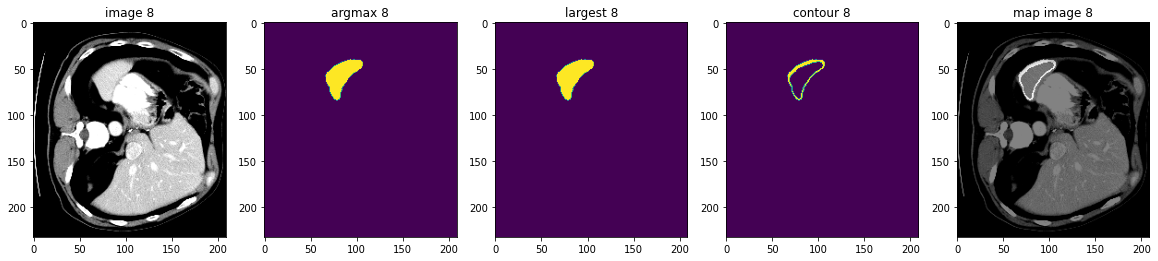

In [12]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data = val_data["image"].to(device)
        val_output = sliding_window_inference(val_data, roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (20, 4))
        plt.subplot(1, 5, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 5, 2)
        plt.title(f"argmax {i}")
        argmax = AsDiscrete(argmax=True)(val_output)
        plt.imshow(argmax.detach().cpu()[0, 0, :, :, 80])
        plt.subplot(1, 5, 3)
        plt.title(f"largest {i}")
        largest = KeepLargestConnectedComponent(applied_labels=[1])(argmax)
        plt.imshow(largest.detach().cpu()[0, 0, :, :, 80])
        plt.subplot(1, 5, 4)
        plt.title(f"contour {i}")
        contour = LabelToContour()(largest)
        plt.imshow(contour.detach().cpu()[0, 0, :, :, 80])
        plt.subplot(1, 5, 5)
        plt.title(f"map image {i}")
        map_image = contour + val_data
        plt.imshow(map_image.detach().cpu()[0, 0, :, :, 80], cmap="gray")
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [13]:
if directory is None:
    shutil.rmtree(root_dir)